# Goal
This notebook idea is to extend the good PyTorch tutorial on generating names https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html
by adding some general PyTorch good pratice to it : batching by using a Dataset/Dalaloader, training using an optimizer,etc.

**data** : https://download.pytorch.org/tutorial/data.zip


**remark**: Some functions could be better implemented but my first idea is to keep the things as close to the tutorial as possible, to focus on the concepts added. ( that might change, this is still just a draft)


In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
from tqdm import tqdm


all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line.strip()) for line in lines]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Korean', 'Japanese', 'Italian', 'English', 'Russian', 'Irish', 'Czech', 'Spanish', 'Portuguese', 'Dutch', 'Greek', 'German', 'Chinese', 'Arabic', 'Scottish', 'Polish', 'Vietnamese', 'French']
O'Neal


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
import random
device="cuda:0" # to use the GPU

In [4]:
class RNN(nn.Module):
    
    def __init__(self, cat_size, input_size, hidden_size, output_size):
        super(RNN,self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(cat_size + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(cat_size + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(output_size + hidden_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def initHidden(self, batchsize=1):
        return torch.zeros(batchsize, self.hidden_size)
    
    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

In [5]:
# The dataset wrap all the function related to data manipulation in a class
# The important functions to notice are __getitem__ which is call when doing dataset[i] to get the i elem of the dataset ( TODO: currently I am still just getting a random sample)
# and the __len__ function that is compusory in any dataset
# more info : https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset 
# tutorial : https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
class namesDs(Dataset):
    
    def __init__(self, category_lines):
        super(Dataset, self).__init__()
        self.category_lines = category_lines
        self.all_categories = list(self.category_lines.keys())
        self.n_categories = len(self.all_categories)
        self.all_letters = string.ascii_letters + " .,;'-"
        self.n_letters = len(self.all_letters) + 1
        self.all_names = ";".join([";".join(self.category_lines[key]) for key in self.category_lines.keys()]).split(';')
        self.size = len(self.all_names)
        self.max_name_size = len(max(self.all_names, key=len))
        
    def __len__(self):
        return self.size
    
    def randomTrainingPair(self):
        category = random.choice(self.all_categories)
        line = random.choice(self.category_lines[category])
        return category, line

    # One-hot vector for category
    def categoryTensor(self, category):
        li = self.all_categories.index(category)
        tensor = torch.zeros(self.n_categories)
        tensor[li] = 1
        return tensor

    # One-hot matrix of first to last letters (not including EOS) for input
    def inputTensor(self, line):
        tensor = torch.zeros(self.max_name_size, self.n_letters)
        for li in range(len(line)):
            letter = line[li]
            tensor[li][self.all_letters.find(letter)] = 1
        return tensor

    # LongTensor of second letter to end (EOS) for target
    def targetTensor(self, line):
        letter_indexes = [self.all_letters.find(line[li]) for li in range(1, len(line))]
        for i in range(len(letter_indexes), self.max_name_size):
            letter_indexes.append(self.n_letters - 1) # EOS Padding
        return torch.LongTensor(letter_indexes)
    
    def __getitem__(self, index):
        category, line = self.randomTrainingPair()
        category_tensor = self.categoryTensor(category)
        input_line_tensor = self.inputTensor(line)
        target_line_tensor = self.targetTensor(line)
        return category_tensor, input_line_tensor, target_line_tensor
            
    def display(self):
        return self.all_categories

        

In [6]:
ds = namesDs(category_lines)

In [7]:
cat_size = len(all_categories)
input_size= len(all_letters)
hidden_size = 128
output_size = len(all_letters)

In [8]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(rnn, optim, category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    
    rnn.zero_grad()
    
    hidden = rnn.initHidden()

    loss = 0
    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()
    optim.step()

    return output, loss.item() / input_line_tensor.size(0)

In [9]:
def train_batch(rnn, optim, category_tensor, input_line_tensor, target_line_tensor):
    
    rnn.zero_grad()
    
    hidden = rnn.initHidden(input_line_tensor.size(0))

    loss = 0
    for i in range(input_line_tensor.size(1)):
        output, hidden = rnn(category_tensor, input_line_tensor[:,i], hidden)
        l = criterion(output, target_line_tensor[:,i])
        loss += l
    
    # compute the gradients
    loss.backward()
    
    # Do the backprop
    optim.step()

    return output, loss.item() / input_line_tensor.size(0)

In [10]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [11]:
import time
rnn = RNN(cat_size, n_letters, hidden_size, n_letters)
lr = 0.0005
# using an optimizer avoids you from having to manually updating the models weigths as in the tutorial
# more info : https://pytorch.org/docs/stable/optim.html
op = optim.Adam(rnn.parameters(), lr = lr)
criterion = nn.NLLLoss()

# the dataloader handle the batching for us!
dl = DataLoader(ds, batch_size=24, shuffle=True)

n_iters = 1000
print_every = 100
plot_every = 10
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()


p = 0
max_epochs = 15
# Loop over epochs

# Training
for epoch in range(max_epochs):
    for cat_t, inp_t, out_t in tqdm(dl):
        # Transfer to GPU
        #local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        output, loss = train_batch(rnn, op, cat_t, inp_t, out_t)
        total_loss += loss
        if p % plot_every == 0:
            all_losses.append(total_loss / plot_every)
            total_loss = 0
        
        

100%|██████████| 837/837 [00:12<00:00, 69.12it/s]


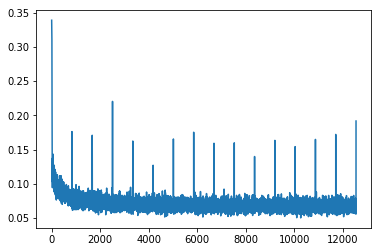

In [334]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [12]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = ds.categoryTensor(category)
        input = ds.inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor.view(1,-1), input[:1], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = ds.inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

print('Fake Russian names:\n')
samples('Russian', 'VTC')
print('\nFake Chinese names:\n')      
samples('Chinese', 'VTC')
print('\nFake French names:\n')
samples('French', 'VTC')
print('\nFake Scottish names:\n')
samples('Scottish', 'VTC')
print('\nFake English names:\n')
samples('English', 'VTC')


Fake Russian names:

Vallanov
Tarkov
Chambong

Fake Chinese names:

Vin
Than
Cha

Fake French names:

Vanter
Toure
Carie

Fake Scottish names:

Vinger
Trichan
Chane

Fake English names:

Vinter
Torgen
Champon
